## B cells in two subjects
The data used in this notebook is lymphocyte data for two patients' B cells. Here, we note presence/absense changes and quantify fold changes using a T test.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
import pandas as pd
data_raw = load_data.load_FragPipe(version='July_noMBR_FP', contains=[])

data_raw

,Blank_3,Blank_4,Blank_5,Subject1_B_cells_062920_C_10,Subject1_B_cells_062920_C_11,Subject1_B_cells_062920_C_12,Subject1_B_cells_062920_C_13,Subject1_B_cells_062920_C_9,Subject1_B_cells_072920_C_4,Subject1_B_cells_072920_C_5,...,Subject2_T_cells_062920_F_12,Subject2_T_cells_062920_F_13,Subject2_T_cells_062920_F_14,Subject2_T_cells_062920_F_9,Subject2_T_cells_072920_F_1,Subject2_T_cells_072920_F_3,Subject2_T_cells_072920_F_4,Subject2_T_cells_072920_F_5,Subject2_T_cells_072920_F_6,Subject2_T_cells_072920_F_8
Protein ID,,,,,,,,,,,,,,,,,,,,,
A0A0B4J2D5,0.0,0.0,0.0,3203277.5,4697996.0,7346776.5,8472867.0,4280919.5,0.0,4787781.50,...,0.0,4905873.00,0.0,3405266.0,4656720.00,1673629.9,6060600.5,2407679.5,7791855.0,5542659.50
A0AVT1,0.0,0.0,0.0,1917388.2,3033529.2,3773018.8,1865758.6,5191332.5,3332031.5,2464089.00,...,1091121.4,630647.25,576871.9,0.0,0.00,0.0,0.0,827356.1,1260652.0,0.00
A0FGR8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,1514363.4,866311.94,0.0,0.0,0.00,0.0,0.0,0.0,653698.6,879074.56
A6NHR9,0.0,0.0,0.0,2650513.5,0.0,3788095.8,0.0,0.0,1845555.5,933499.44,...,0.0,0.00,0.0,0.0,430484.97,0.0,0.0,0.0,538303.6,948190.40
A8K2U0,0.0,0.0,0.0,0.0,0.0,0.0,1149867.8,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
O15068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00
Q14C86,0.0,0.0,0.0,0.0,0.0,1139333.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,1029046.4,0.00
Q8N4T8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00


These are some methods that check if a value was measured or not and if the protein was measured in each type.

In [2]:
import data_utils
from numpy import nan
from numpy import log2
from statistics import median, mean

Here we record which proteins are only identified in one cell type. We'll set these aside for now, in the <code>data_in_one_type</code> dataframe. Note that <code>min_reps</code> is the minimum number of replicates required to list a protein as present in one type. This can be changed, i.e., <code>min_reps=5</code> to determine the proteins identified in all 5 replicates of a single type; do not set it to a number greater than the replicates run or no proteins will be returned.

In [3]:
types = ['Subject1_B_cells_062920', 'Subject2_B_cells_062920']
types = ["B_cells_062920","B_cells_072920", "T_cells_062920",  "T_cells_072920"]

all_cell_types = ["1_B_cells_062920","1_B_cells_072920", "2_B_cells_062920",  "2_B_cells_072920",
              "1_T_cells_062920","1_T_cells_072920","2_T_cells_062920", "2_T_cells_072920"]

Next, we select the proteins that are measured in at least half the samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [4]:
data_log2 = log2(data_raw.replace(0,nan))
indecies = data_log2.apply(data_utils.check_n_of_each_type,
                                      axis=1, cell_types=all_cell_types, min_reps=3)
data_filtered = data_log2[indecies]

Before any analysis, we log normalize and median normalize across runs.

In [5]:
data = data_filtered.apply(lambda series: series-median(series.dropna()))

In [6]:
print ("Total groups identified:")
print(data_raw.shape[0])

print ("Proteins identified in at least 3 of each cell type:\t")
print (data.shape[0])

Total groups identified:
2426
Proteins identified in at least 3 of each cell type:	
887


Now we calulate p values using a ttest. 

In [7]:
#Call ttest function
tstats_B = data.apply(data_utils.ttest_wrapper, axis=1, cell_types=["B_cells_062920", "B_cells_072920"])
tstats_T = data.apply(data_utils.ttest_wrapper, axis=1, cell_types=["T_cells_062920", "T_cells_072920"])


D:\Program_Files\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Here we calculate fold change.

In [8]:
tstats_B['log2(B1)-log2(B2)'] = data.apply(data_utils.get_fold_changes, axis=1,
                                         cell_types=["B_cells_062920", "B_cells_072920"])
tstats_T['log2(T1)-log2(T2)'] = data.apply(data_utils.get_fold_changes, axis=1,
                                         cell_types=["T_cells_062920", "T_cells_072920"])

Fold change and p values allow us to create a volcano plot.

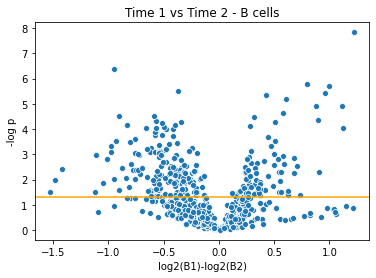

In [9]:
#graph volcano
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10
tstats_B['-log p'] = -log10(tstats_B['pvalue'])
tstats_T['-log p'] = -log10(tstats_T['pvalue'])

figure = sns.scatterplot(x='log2(B1)-log2(B2)',y='-log p',data=tstats_B)
figure.set_title("Time 1 vs Time 2 - B cells")
#plt.axvline(1, color ='orange')
#plt.axvline(-1, color ='orange')
plt.axhline(-log10(.05), color ='orange')
plt.show()

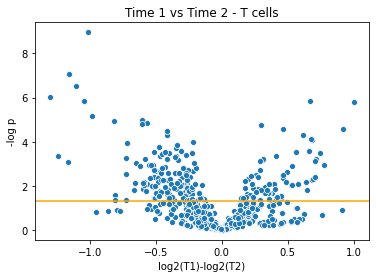

In [10]:
figure = sns.scatterplot(x='log2(T1)-log2(T2)',y='-log p',data=tstats_T)
figure.set_title("Time 1 vs Time 2 - T cells")
#plt.axvline(1, color ='orange')
#plt.axvline(-1, color ='orange')
plt.axhline(-log10(.05), color ='orange')
plt.show()

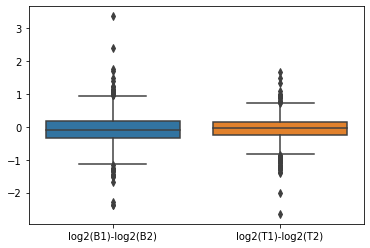

In [11]:
sns.boxplot(data=pd.concat([tstats_B, tstats_T])[['log2(B1)-log2(B2)','log2(T1)-log2(T2)']])

plt.savefig("data/BT_regulation_changes.png", dpi=300)

In [12]:
cell_types = ["1_B_cells_062920","1_B_cells_072920", "2_B_cells_062920",  "2_B_cells_072920",
              "1_T_cells_062920","1_T_cells_072920","2_T_cells_062920", "2_T_cells_072920"]

indecies = data.apply(data_utils.check_n_of_each_type, axis=1, cell_types=cell_types)
data = data[indecies]

categories =["Subject1_B_cells","Subject2_B_cells","Subject1_T_cells","Subject2_T_cells"]

summary = {}
for c in categories:
    summary["{0}".format(c)] = data.apply(data_utils.get_fold_changes, axis=1,
                             cell_types=["{0}_062920".format(c), "{0}_072920".format(c)])
summary = pd.DataFrame(summary)

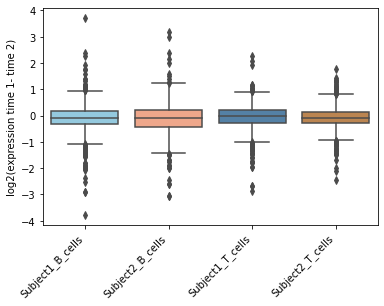

In [13]:
fig = plt.figure()
ax = sns.boxplot(data=summary, palette  = ['skyblue', 'lightsalmon', 'steelblue',  'peru'])

ax.set(ylabel="log2(expression time 1- time 2)")

plt.xticks(rotation=45, ha='right')
plt.savefig("data/regulation_changes_byTypeandSub.png", dpi=300, bbox_inches='tight')

Next we will identify the altered proteins.

In [16]:
altered_B = tstats_B.apply(data_utils.is_altered, axis=1, cell_types=types, 
                           change_factor=False, change_col= 'log2(B1)-log2(B2)').dropna()
altered_T = tstats_T.apply(data_utils.is_altered, axis=1, cell_types=types,
                           change_factor=False, change_col= 'log2(T1)-log2(T2)').dropna()

These are significantly altered (p<0.01) without restricting by the magnitude of change:

In [17]:
altered_B.value_counts()

B_cells_072920    108
B_cells_062920     46
dtype: int64

In [18]:
altered_T.value_counts()

B_cells_072920    89
B_cells_062920    42
dtype: int64

### Differentially expressed proteins

This shows the differentially expressed proteins. Recall that this dataset is restricted to those expressed in at least three of each cell type.

The next step is to identify those proteins by name. Here we get the protein names from the fasta file, which remain the same regardless of which software the data was quantified using.

In [19]:
protein_names = load_data.load_fasta()

In [20]:
import pandas as pd
protein_names_by_group={}
for ID in data_raw.index:
    if ';' in ID:
        ids = ID.split(';')
        names=''
        for i in ids:
            if i in protein_names.index:
                names=names + protein_names[i] + ';'
        names = names[:-1]
        protein_names_by_group[ID] = names
    else:
        if ID in protein_names.index:
            protein_names_by_group[ID]=protein_names[ID]
protein_names_by_group = pd.Series(list(protein_names_by_group.values()), index=protein_names_by_group.keys())

Here we add the names to the <code>tstats</code> dataframe, which contains the fold changes for each protein. Then we can list the proteins that are altered. Optionally, use <code> head()</code> to display the first few or <code>to_csv</code> to write out to a file. We now split up the proteins heightened in B cells from those heightened in T cells.

In [21]:
tstats_B['Name']=protein_names_by_group
tstats_B['GeneID'] = tstats_B.Name.apply(lambda n: str(n).split('_HUMAN')[0])

altered_proteins_B = tstats_B.loc[altered_B.index].sort_values('log2(B1)-log2(B2)',
                        ascending=False)[['pvalue','log2(B1)-log2(B2)','Name','GeneID']]
higher_in_B_June = altered_proteins_B.loc[altered_proteins_B['log2(B1)-log2(B2)'] >0]
higher_in_B_July = altered_proteins_B.loc[altered_proteins_B['log2(B1)-log2(B2)'] <0]

#To write out to a file, use:
#altered_proteins.to_csv('data/filename.tsv', sep='\t')

In [22]:
tstats_T['Name']=protein_names_by_group
tstats_T['GeneID'] = tstats_T.Name.apply(lambda n: str(n).split('_HUMAN')[0])

altered_proteins_T = tstats_T.loc[altered_T.index].sort_values('log2(T1)-log2(T2)',
                        ascending=False)[['pvalue','log2(T1)-log2(T2)','Name','GeneID']]
higher_in_T_June = altered_proteins_T.loc[altered_proteins_T['log2(T1)-log2(T2)'] >0]
higher_in_T_July = altered_proteins_T.loc[altered_proteins_T['log2(T1)-log2(T2)'] <0]

#To write out to a file, use:
#altered_proteins.to_csv('data/filename.tsv', sep='\t')

### Proteins Higher in B Cells in June:

In [23]:
higher_in_B_June.sort_values('log2(B1)-log2(B2)',ascending=True).head()

,pvalue,log2(B1)-log2(B2),Name,GeneID
Protein ID,,,,
Q96KP4,0.003078,0.232209,CNDP2_HUMAN Cytosolic non-specific dipeptidase,CNDP2
P20700,0.005503,0.236350,LMNB1_HUMAN Lamin-B1,LMNB1
P27348,0.004976,0.238222,1433T_HUMAN 14-3-3 protein theta,1433T
Q01518,0.009793,0.245295,CAP1_HUMAN Adenylyl cyclase-associated protein 1,CAP1
P78371,0.004888,0.245328,TCPB_HUMAN T-complex protein 1 subunit beta,TCPB


### Proteins Higher in B Cells in July:

In [24]:
higher_in_B_July.sort_values('log2(B1)-log2(B2)',ascending=True).head()

,pvalue,log2(B1)-log2(B2),Name,GeneID
Protein ID,,,,
P26368,0.003981,-1.422720,U2AF2_HUMAN Splicing factor U2AF 65 kDa subunit,U2AF2
P69891,0.001078,-1.112155,HBG1_HUMAN Hemoglobin subunit gamma-1,HBG1
P69892,0.001077,-1.112144,HBG2_HUMAN Hemoglobin subunit gamma-2,HBG2
P26447,0.001585,-1.009301,10A4_HUMAN Protein S100-A4,10A4
P09382,0.000468,-0.980316,LEG1_HUMAN Galectin-1,LEG1


### Proteins Higher in June in T Cells:

In [25]:
higher_in_T_June.sort_values('log2(T1)-log2(T2)',ascending=True).head()

,pvalue,log2(T1)-log2(T2),Name,GeneID
Protein ID,,,,
Q01518,0.005756,0.178862,CAP1_HUMAN Adenylyl cyclase-associated protein 1,CAP1
P23246,0.004755,0.201199,"FPQ_HUMAN Splicing factor, proline- and glutam...",FPQ
P31146,0.003668,0.222737,COR1A_HUMAN Coronin-1A,COR1A
P10412,0.008323,0.232036,H14_HUMAN Histone H1.4,H14
P22626,0.003077,0.257690,ROA2_HUMAN Heterogeneous nuclear ribonucleopro...,ROA2


### Proteins Higher in June in T Cells:

In [26]:
higher_in_T_July.sort_values('log2(T1)-log2(T2)',ascending=True).head()

,pvalue,log2(T1)-log2(T2),Name,GeneID
Protein ID,,,,
P68871,9.747993e-07,-1.302454,HBB_HUMAN Hemoglobin subunit beta,HBB
P00761,4.650775e-04,-1.238223,NaN,nan
Q00013,8.469257e-04,-1.165466,EM55_HUMAN 55 kDa erythrocyte membrane protein,EM55
P02042,8.127019e-08,-1.153784,HBD_HUMAN Hemoglobin subunit delta,HBD
P30043,3.107636e-07,-1.104348,BLVRB_HUMAN Flavin reductase (NADPH),BLVRB
